# <center> Assignment 02: Detect your favorite animal <br> <br> <small>16 January 2023</small> </center>

The goal of this assignment is :

    - Place a square around my favorite animal in selected images.
    - Compare the accuracies between models.

In [2]:
# For the google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.7/699.7 kB 10.2 MB/s eta 0:00:00


## Import libraries

In [74]:
from ultralytics import YOLO
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Lambda, Dropout, Input, GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2
from PIL import ImageDraw, Image
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import shutil
import os
import numpy as np
warnings.filterwarnings("ignore")

## Data preparation

I took the dataset from [kaggle](https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset/data), the dataset contains many images of different animals. I chose to build a model that can detect Eagle.

Below are the steps required to prepare the input data for both the baseline model and YOLO model. Some of these steps are intended for local use on my machine but some problems occurred so I migrated to Google colab.



In [ ]:
# Define the folders to move images
kaggle = "../Assignment 2/data/kaggle"
train_imgs_path = os.path.join(kaggle, "train", "Eagle")
train_labels_path = os.path.join(kaggle, "train", "Eagle", "Label")
val_imgs_path = os.path.join(kaggle, "test", "Eagle")
val_labels_path = os.path.join(kaggle, "test", "Eagle", "Label")
train_path = "../Assignment 2/data/train"
val_path = "../Assignment 2/data/val"

The folder structure of this assigment from my folder is:

![](https://github.com/raydiwill/Computer-Vision-DSA-2023/assets/97393390/b237457b-ab20-4c3c-a6cd-f3bb0d71069f)

Where I stored all the images from Kaggle into one folder, then I moved the Eagle images to two kinds of folder. One for the baseline model and one for YOLO. Because the label in the txt file is in the format of {Label}{x min}{y min}{x max}{y max}. So I need to also convert that file for the YOLO format as well.

In [ ]:
# Create train and val folder for YOLO
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(train_path + '/images', exist_ok=True)
os.makedirs(train_path + '/labels', exist_ok=True)
os.makedirs(val_path + '/images', exist_ok=True)
os.makedirs(val_path + '/labels', exist_ok=True)

In [ ]:
# Gettings the file names and labels to copy files
train_eagle_imgs = [file for file in os.listdir(train_imgs_path) if file.endswith('.jpg')]
train_eagle_labels = [file for file in os.listdir(train_labels_path)]
val_eagle_imgs = [file for file in os.listdir(val_imgs_path) if file.endswith('.jpg')]
val_eagle_labels = [file for file in os.listdir(val_labels_path)]

In [ ]:
# Copy images to folders for YOLO
def move_file(files, src, dest):
    for file in tqdm(files):
        shutil.copy(os.path.join(src, file), os.path.join(dest, file))

In [ ]:
move_file(train_eagle_imgs, train_imgs_path, os.path.join(train_path, "images"))
move_file(train_eagle_labels, train_labels_path, train_path + '/labels')
move_file(val_eagle_imgs, val_imgs_path, os.path.join(val_path, "images"))
move_file(val_eagle_labels, val_labels_path, os.path.join(val_path, "labels"))

100%|██████████| 178/178 [00:00<00:00, 10371.12it/s]


In [5]:
# Dataframe stored the images infos
df = pd.DataFrame(
    columns = ["class", "path", "x_min", "y_min", "x_max", "y_max"]
)

In [6]:
# For the colab to run
gg_train_path = '/content/drive/My Drive/Colab Notebooks/CV/train/'

In [7]:
for filename in tqdm(os.listdir(gg_train_path + "labels")):
    with open(os.path.join(gg_train_path, "labels", filename), "r") as file:
        name_without_extension = os.path.splitext(filename)[0]
        image_file_path = os.path.join(gg_train_path + 'images', name_without_extension + '.jpg')
        for line in file:
            parts = line.strip().split()
            x_min = float(parts[1])
            y_min = float(parts[2])
            x_max = float(parts[3])
            y_max = float(parts[4])

            row = {"class": 0, "path": image_file_path, "x_min": x_min, "y_min": y_min, "x_max": x_max, "y_max": y_max}
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

100%|██████████| 719/719 [00:26<00:00, 26.75it/s] 


In [8]:
df.head()

,class,path,x_min,y_min,x_max,y_max
0,0,/content/drive/My Drive/Colab Notebooks/CV/tra...,47.36,206.079744,466.56,440.319744
1,0,/content/drive/My Drive/Colab Notebooks/CV/tra...,309.12,81.370571,681.60,510.648365
2,0,/content/drive/My Drive/Colab Notebooks/CV/tra...,329.60,17.295075,903.68,834.640373
3,0,/content/drive/My Drive/Colab Notebooks/CV/tra...,430.08,191.550999,599.04,270.350190
4,0,/content/drive/My Drive/Colab Notebooks/CV/tra...,248.32,343.969002,528.64,546.379184


The label files are not normalized, so I need to normalize it for the baseline model.

In [23]:
images = []
bboxes = []
size = 224

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    img = load_img(row['path'])
    w, h = img.size
    x_scale = size / w
    y_scale = size / h
    img = img.resize((size, size))
    array_img = img_to_array(img, dtype="float32")
    images.append(array_img)

    x_min = int(row["x_min"] * x_scale) / size
    y_min = int(row["y_min"] * y_scale) / size
    x_max = int(row["x_max"] * x_scale) / size
    y_max = int(row["y_max"] * y_scale) / size

    bboxes.append((x_min, y_min, x_max, y_max))

100%|██████████| 761/761 [00:14<00:00, 53.41it/s]


In [24]:
images = np.array(images, dtype="float32") / 255.0
bboxes = np.array(bboxes, dtype="float32")

The label files contains the bounding box data, but at its own size. If I want to resize the image for the training of my model, I have to also resize the bounding box to match the size of the newly resized image.

## Model training

Here, I trained two model, a baseline with MobileNetV2 pretrained model and a YOLO model as the comparison model.

In [25]:
train_images, test_images, train_bbox, test_bbox = train_test_split(images, bboxes, test_size=0.2, random_state=42)

### Baseline model

#### Training

base_model = Sequential()

base_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
base_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
base_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
base_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
base_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
base_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
base_model.add(Flatten())

bbox_layer = Dense(128, activation='relu')(base_model.output)
bbox_output = Dense(4, activation='sigmoid', name='bbox')(bbox_layer)

# Final model
model_1 = Model(inputs=base_model.input, outputs=bbox_output)

model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model_1.summary()

model_1.fit(train_images, train_bbox, batch_size=64, epochs=5, validation_data=(test_images, test_bbox))

This was my first try, there were some problems with my machine that this CNN model couldn't run at all, so I tried the transfer learning approach in the next blocks.

In [26]:
# I randomly chose MobileNetV2 as the baseline because the YOLO will be better than this
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = False

model_2 = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='sigmoid')
])

9406464/9406464 [==============================] - 0s 0us/step


In [27]:
model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [28]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 657

In [29]:
model_2.fit(train_images, train_bbox, batch_size=64, epochs=10, validation_data=(test_images, test_bbox), verbose=1)

Epoch 1/10
10/10 [==============================] - 28s 3s/step - loss: 0.0811 - accuracy: 0.4934 - val_loss: 0.0796 - val_accuracy: 0.5098
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.0768 - accuracy: 0.5230 - val_loss: 0.0723 - val_accuracy: 0.5098
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.0702 - accuracy: 0.5247 - val_loss: 0.0688 - val_accuracy: 0.5098
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 0.0648 - accuracy: 0.5247 - val_loss: 0.0580 - val_accuracy: 0.5098
Epoch 5/10
10/10 [==============================] - 22s 2s/step - loss: 0.0566 - accuracy: 0.5247 - val_loss: 0.0588 - val_accuracy: 0.5098
Epoch 6/10
10/10 [==============================] - 20s 2s/step - loss: 0.0531 - accuracy: 0.5247 - val_loss: 0.0573 - val_accuracy: 0.5098
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.0505 - accuracy: 0.5263 - val_loss: 0.0404 - val_accuracy: 0.5621
Epoch 8/10
10/10 [==

> The accuracy of this model is good enough with 57% accuracy.

#### Testing

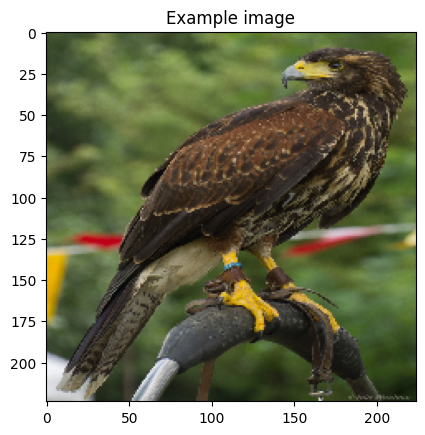

In [91]:
# Load a random image to test the model ability to detect the animal
img_test = load_img("/content/drive/My Drive/Colab Notebooks/CV/val/images/706214bbe9143ccc.jpg", target_size=(224, 224))
plt.imshow(img_test)
plt.title("Example image")
plt.show()

In [46]:
img_array = img_to_array(img_test, dtype='float32')
img_reshaped = img_array.reshape((1, 224, 224, 3))
img_reshaped_norm = img_reshaped / 255

In [53]:
test_pred_1 = model_2.predict(img_reshaped_norm)
box = test_pred_1[0] * 224
box

1/1 [==============================] - 0s 41ms/step


array([ 0.00016255,      23.441,      203.86,      211.73], dtype=float32)

In [54]:
# Get the x and y data
pred_x_min, pred_y_min, pred_x_max, pred_y_max = np.array(box)

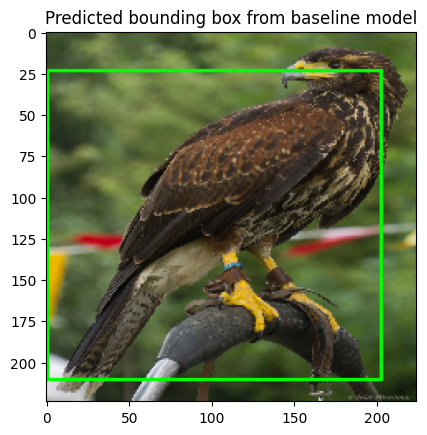

In [81]:
# Create a drawing context
draw = ImageDraw.Draw(img_test)

# Draw the bounding box
draw.rectangle([pred_x_min, pred_y_min, pred_x_max, pred_y_max], outline=(0, 255, 0), width=2)

# Display the image
plt.imshow(img_test)
plt.title('Predicted bounding box from baseline model')
plt.show()

> Clearly the baseline model is not able to detect the animal perfectly as we can see from the image.

### YOLO

To train a YOLO model, we need to structure the folders into *train* and *val*, each would have *images* and *labels* inside. The label txt files should be also in the format {label}{x center}{y center}{width}{height}

#### Training

In [41]:
def create_yolo_labels(df, labels_folder, class_id=0):
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        img = load_img(row['path'])
        img_width, img_height = img.size

        x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        x_center = ((x_min + x_max) / 2) / img_width
        y_center = ((y_min + y_max) / 2) / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        label_text = f"{class_id} {x_center} {y_center} {width} {height}\n"

        image_filename = os.path.basename(row['path'])
        label_filename = os.path.splitext(image_filename)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_filename)

        with open(label_path, 'w') as label_file:
            label_file.write(label_text)

# Example usage
# df is your DataFrame with the necessary columns
# create_yolo_labels(df, 'path/to/images/folder', 'path/to/labels/folder')

> The above block was intended for local use, I did the inefficient way by generating labels locally then uploaded to Google colab.

In [66]:
# Download model
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 238MB/s]


In [19]:
!ls "/content/drive/My Drive/Colab Notebooks/CV/"

eagle.yaml  KhanhDuong_TRAN_Assignment_2.ipynb	train  train_2	val  val_2


To train the YOLO, I also need to create a yaml file for the model to recognize which folders it should train and validate from.

In [67]:
results = model.train(
    data="/content/drive/My Drive/Colab Notebooks/CV/eagle.yaml", epochs=5, imgsz=320
)

Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/My Drive/Colab Notebooks/CV/eagle.yaml, epochs=5, time=None, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 755k/755k [00:00<00:00, 24.6MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 225 layers, 11135987 parameters, 11135971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
requirements: Ultralytics requirement ['hub-sdk>=0.0.2'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 6.7s, installed 1 package: ['hub-sdk>=0.0.2']
requiremen

train: Scanning /content/drive/My Drive/Colab Notebooks/CV/train_2/labels.cache... 719 images, 0 backgrounds, 0 corrupt: 100%|██████████| 719/719 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/My Drive/Colab Notebooks/CV/val_2/labels.cache... 178 images, 0 backgrounds, 0 corrupt: 100%|██████████| 178/178 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G     0.8284      1.067      1.113         40        320: 100%|██████████| 45/45 [05:07<00:00,  6.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:12<00:00, 12.16s/it]

                   all        178        178       0.73      0.787      0.837      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      0.996      1.016      1.206         36        320: 100%|██████████| 45/45 [04:53<00:00,  6.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.15s/it]

                   all        178        178      0.458      0.674      0.562       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G     0.9878     0.9726      1.188         32        320: 100%|██████████| 45/45 [04:50<00:00,  6.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:24<00:00,  4.16s/it]

                   all        178        178      0.567      0.618      0.628      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G     0.9261     0.8889      1.154         37        320: 100%|██████████| 45/45 [04:54<00:00,  6.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.20s/it]

                   all        178        178      0.725      0.669      0.714      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.8884     0.8437      1.145         34        320: 100%|██████████| 45/45 [04:51<00:00,  6.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.18s/it]

                   all        178        178      0.799      0.927      0.939      0.782



5 epochs completed in 0.461 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.2 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.18s/it]


                   all        178        178        0.8      0.927      0.939      0.782
Speed: 0.3ms preprocess, 114.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


> After researching how to evaluate the YOLO model, I found that the two numbers: **Box** and **mAP50** are the most important to know if the model performed well or not. And from the output, my model with the Box being 87% and mAP50 93% are good.

Text(0.5, 1.0, 'Predefined Labels')

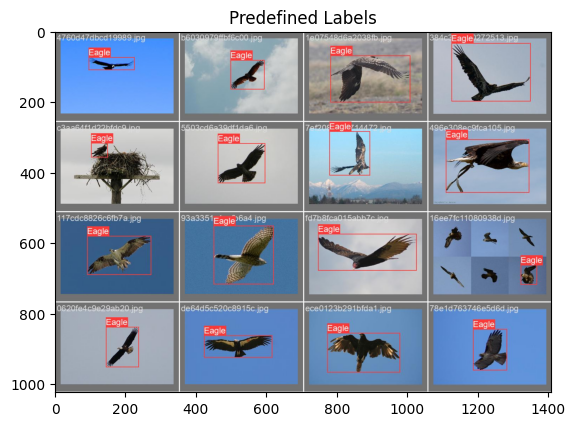

In [89]:
plt.imshow(load_img("/content/runs/detect/train/val_batch1_labels.jpg"))
plt.title("Predefined Labels")

Text(0.5, 1.0, 'YOLO predicted for validation batch')

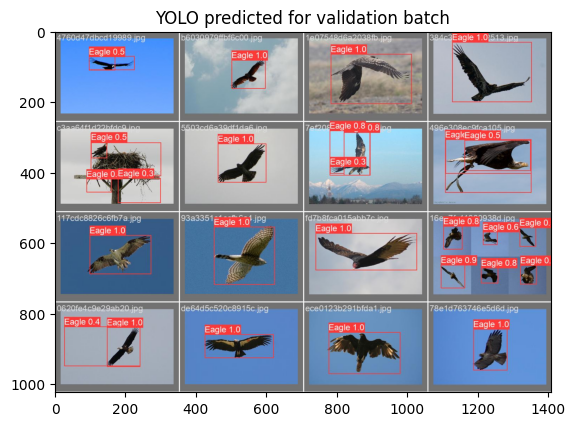

In [88]:
plt.imshow(load_img("/content/runs/detect/train/val_batch1_pred.jpg"))
plt.title("YOLO predicted for validation batch")

#### Testing

In [72]:
# Load random image to test
test_model = YOLO("/content/runs/detect/train/weights/best.pt")

In [75]:
image_test_2 = load_img("/content/drive/My Drive/Colab Notebooks/CV/val/images/dae5282f7b228f86.jpg")
pred_result = test_model.predict([image_test_2], imgsz=320)
pred_img_result = pred_result[0]


0: 224x320 1 Eagle, 232.9ms
Speed: 1.3ms preprocess, 232.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


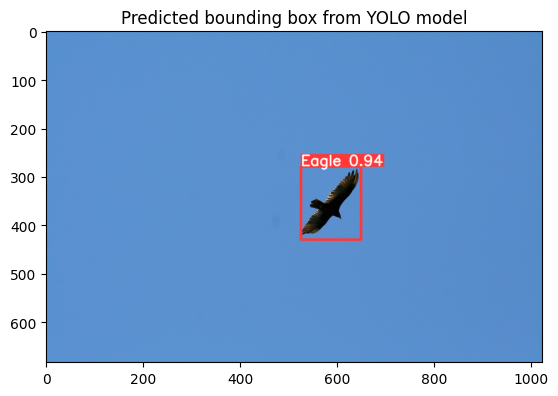

In [82]:
for result in pred_img_result:
    img_array = result.plot()
    img = Image.fromarray(img_array[..., ::-1])
    plt.title('Predicted bounding box from YOLO model')
    plt.imshow(img)

> With the YOLO model, the detection of the animal is much better.